# Population Sustainability in Japan
## Yu Cao, Nick Williams, Aidan McGovern


## Introduction 

Over the better part of the 20th century, Japan has transformed itself from a primarily agrarian society into a modern industrial super power. While japanese life expectancy has increased substantially over time, the effects of industrialization have pressured the japanese population to prioritize their place in the workforce over reproduction. As a result, the life expectancy of the Japanese has increased while the birth rate has experienced a consistent decline. Some sources predict a negative japanese birth rate as early as 2020. 

In this project, we will be exploring factors we believe are related to population decline in Japan. According to the [Population Reference Bureau]("https://www.prb.org/"), the only three factors related to population change are migration rate, birth rate, and death rate. Though these factors are comprehensive to a degree, we don't believe that they completely adress the root cuases of decline. The objective of this project is to indentify factors that we believe are related to population decline, prove their relation, then determine the degree to which they matter.

# Part 1 - Exploratory Data Analysis


What can we observe from the raw population data of Japan

### Retrieve Japanese Population Dataset

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

r = requests.get("https://raw.githubusercontent.com/eyucao/csvhold/master/Japan_population_data.csv")
df = BeautifulSoup(r.text)

### Clean the data

In [2]:
df2 = df.getText().split('\n')
i = 0
df3 = []
for line in df2:
    if i == 0:
        colnames = line.split(',')
        i = 1
    else:
        df3.append(line.split(','))
df3 = df3[:-1]
colnames[6] = colnames[6][:-1]
population_data = pd.DataFrame(data = df3, columns = colnames)
population_data.dropna()
population_data.reset_index(drop=True, inplace = True)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,islan
0,Aichi-ken,1872.1667,1210368,Nagoya-shi,Chubu,5165.12,Honshu
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu


I started my cleaning here. Dropping all the NaN/empty values was my first priority. Then I renamed my columns but I noticed a '\r' escape character present in both my column names as well as the island column. To rectify the column name, I simply set the sixth entry(island), equal to itself but with the last character removed. I also dropped the last row as it contained all None values that dropna didn't pick up when I tried this before.

### Calculate the Rate of Change in Population

In [3]:
population_data.head(10)

for index, row in population_data.iterrows():
    row['year'] = int(float(row['year']))

prev = {}
popdelta = {}
population_data = population_data[population_data.population != 'NA']
population_data.reset_index(drop=True, inplace = True)
for index, row in population_data.iterrows():
    if row['prefecture'] in prev:
        popdelta[index] = int(row['population']) - int(prev[row['prefecture']])
        prev[row['prefecture']] = row['population']
    else:
        popdelta[index] = 0
        prev[row['prefecture']] = row['population']

In [4]:
population_data['pop_delta'] = 1
for index,row in population_data.iterrows():
    if index in popdelta.keys():
        population_data.iat[index,7] = popdelta[index]
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,islan,pop_delta
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980


I then calculated the population change in each prefecture. I did this by calculating the previous row's population and simply looking at the delta. The issue with using the widely used method of shift is that our data is dependent on the prefecture. So for us to get relevant population change per year per prefecture, we have to do it manually. It looks ugly but it does what it needs to do.

After creating a dummy column for this new feature, I run through the dictionary I've created that has mapped indices to the population change per year. I then run through this dictionary in a for loop and utilize the .iat method to place these datapoints in their correct respective locations.

### Calculate the Rate of Change in Population Change

In [5]:
pref = {}
for index, row in population_data.iterrows():
    if row['prefecture'] not in pref.keys():
        pref[row['prefecture']] = 0
#need to get delta delta
population_data['pop_delta_delta'] = -1 *(population_data['pop_delta'] - population_data['pop_delta'].shift(-1))
population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(1)

population_data['pdd_percent'] = -1 *(population_data['pop_delta_delta'].shift(-1) / population_data['pop_delta'])
population_data['pdd_percent'] = population_data['pdd_percent'].shift(1)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,islan,pop_delta,pop_delta_delta,pdd_percent
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0,NaN,NaN
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076,7076.0,-inf
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77,-6999.0,0.989118
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482,16405.0,-213.051948
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708,-5774.0,0.350322
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128,-4580.0,0.427718
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367,10239.0,-1.670855
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246,11879.0,-0.725790
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360,-19886.0,0.704029
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980,5620.0,-0.672249


In [6]:
prevs = []

for index, row in population_data.iterrows():
    #print(row['prefecture'])
    if row['prefecture'] not in prevs:
        prevs.append(row['prefecture'])
        population_data.iat[index,9] = 0
        population_data.iat[index,8] = 0
#print(prevs)

population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(-1)
population_data['pdd_percent'] = population_data['pdd_percent'].shift(-1)
prevs.clear()
for index, row in population_data.iterrows():
    #print(row['prefecture'])
    if row['prefecture'] not in prevs:
        prevs.append(row['prefecture'])
        population_data.iat[index,9] = 0
        population_data.iat[index,8] = 0

population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(1)
population_data['pdd_percent'] = population_data['pdd_percent'].shift(1)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,islan,pop_delta,pop_delta_delta,pdd_percent
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0,NaN,NaN
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076,0.0,0.000000
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77,-6999.0,0.989118
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482,16405.0,-213.051948
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708,-5774.0,0.350322
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128,-4580.0,0.427718
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367,10239.0,-1.670855
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246,11879.0,-0.725790
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360,-19886.0,0.704029
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980,5620.0,-0.672249


Now we can use shift to see the change in population change per year per prefecture(population delta delta). After doing our shift, both our population change change and percent population delta delta are off by a position of one and have extraneous entries in the intersection between features(remember the problem we had earlier with not being able to use shift).

This situation is different though! We can do our shifting, and then simply go through and set the rows where a new prefecture begins values of population delta delta and percent delta delta to zero. Done!

### Put All Computed Features Together

In [22]:
pop_yr = {}
#get the sum of all prefectures per year
for index, row in population_data.iterrows():
    if row['year'] in pop_yr:
        #print(row['population'])
        pop_yr[row['year']] += int(row['population'])
    else:
        pop_yr[row['year']] = 0
#make it a dataframe
total_pop = pd.DataFrame([list(pop_yr.keys()),list(pop_yr.values())])
total_pop = total_pop.T
total_pop.columns = ['year','population']
total_pop.iat[14,1] = int(total_pop.iat[14,1] /2)
total_pop.head(10)

,year,population
0,1872,26858564
1,1873,27840112
2,1874,29388390
3,1875,29718092
4,1876,30590571
5,1877,33377526
6,1878,33631370
7,1879,34473104
8,1880,34625009
9,1881,35041202


Now that we know this, we sum up all yearly totals across prefectures per year to get a cumulative sum per year. Index 14 is double counted due to a bug, so we just rectify the value by dividing it in two. After we do this, we now are left with a year by year population table. However, this data has little use as we are more interested in both the population delta and population delta delta(and the percent change). We use our good friend shift once again and end up where we want.

In [8]:
#get changes based on previous row's pop
total_pop['pop_delta'] = -1 *( total_pop['population'] - total_pop['population'].shift(-1))
total_pop['pop_delta'] = total_pop['pop_delta'].shift(1)
#same but for pop_delta
total_pop['pop_delta_delta'] = -1* ( total_pop['pop_delta'] - total_pop['pop_delta'].shift(-1))
total_pop['pop_delta_delta'] = total_pop['pop_delta_delta'].shift(1)
#calculate the percent change
total_pop['pd_decrease'] = -1 * ( total_pop['pop_delta_delta'].shift(-1) / total_pop['pop_delta'])
#total_pop['pop_delta_delta'] = total_pop['pop_delta_delta'].shift(1)
total_pop['pd_decrease'] = total_pop['pd_decrease'].shift(1)
#move everything back to where it's supposed to be, and make them numbers
total_pop['year'] = pd.to_numeric(total_pop['year'], errors='coerce')
#rename column
total_pop.rename(columns={'year':'Year'}, inplace=True)

total_pop.head()

,Year,population,pop_delta,pop_delta_delta,pd_decrease
0,1872,26858564,NaN,NaN,NaN
1,1873,27840112,981548.0,NaN,NaN
2,1874,29388390,1548278.0,566730.0,-0.577384
3,1875,29718092,329702.0,-1218576.0,0.787052
4,1876,30590571,872479.0,542777.0,-1.646265


# Part 2 - Analysis of Factors

We're now going to take a look at some other attributes of Japan to determine if we can relate them to Japan's population rate of change.

At this point, we bring in relevant data generally associated with population decline(fertility and mortality as per the Population Reference Bureau's recommendation) as well as many that are not conventionally used. We now need to establish that these datasets present a somewhat linear relationship to a decline in population change.

### Retrieve and Clean Japanese Urban Population Data

In [9]:
world_urban_pop = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_urban_population.csv")
world_urban_pop

japan_urban_pop = world_urban_pop[world_urban_pop['Country Name'] == 'Japan']

japan_urban_pop = japan_urban_pop.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_urban_pop['Year'] = japan_urban_pop.index
japan_urban_pop.columns = ['urban_population_count', 'Year']


japan_urban_pop.index = [i for i in range(0,len(japan_urban_pop.index))]
japan_urban_pop
japan_urban_pop['Year'] = pd.to_numeric(japan_urban_pop['Year'], errors='coerce')
japan_urban_pop['urban_population_count'] = pd.to_numeric(japan_urban_pop['urban_population_count'], errors='coerce')
japan_urban_pop.plot.line(x='Year', y='urban_population_count')

### Retrieve and Clean Japanese Urban Population Change Data

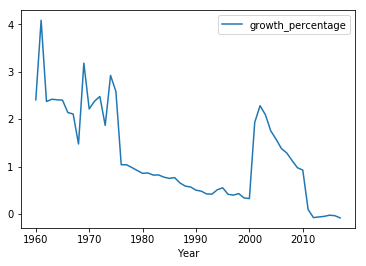

In [10]:
r3 = requests.get("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_urban_population_growth.csv")
raw_world_urb_pop_growth = BeautifulSoup(r3.text)

raw_world_urb_pop_growth = raw_world_urb_pop_growth.getText().split("\n")[4:]

cols = None

urb_pop_growth_obs = []

for obs in raw_world_urb_pop_growth:
  if cols is not None:
    urb_pop_growth_obs.append(obs.replace("\"", '').split(",")[:-1])
  else:
    cols = obs.replace("\"", '').split(",")    
    
df = pd.DataFrame(data=urb_pop_growth_obs, columns = cols)
df
urb_pop_growth = df[df['Country Name'] == 'Japan']
urb_pop_growth = urb_pop_growth.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code' ]).T

urb_pop_growth['Year'] = urb_pop_growth.index
urb_pop_growth.columns = ['growth_percentage', 'Year']
urb_pop_growth.index = [i for i in range(0,len(urb_pop_growth.index))]

urb_pop_growth['Year'] = pd.to_numeric(urb_pop_growth['Year'], errors='coerce')
urb_pop_growth['growth_percentage'] = pd.to_numeric(urb_pop_growth['growth_percentage'], errors='coerce')
urb_pop_growth.plot.line(x='Year', y='growth_percentage')

### Retrieve and Clean Japanese Fertility Rate (births per woman)

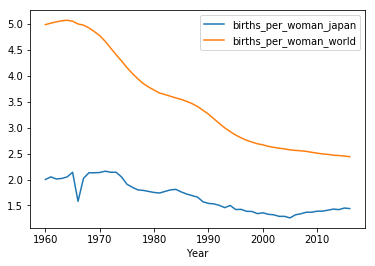

In [11]:
raw_world_fert_rates = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_fertility_rates.csv")
raw_world_fert_rates

japan_fert_rate = raw_world_fert_rates[raw_world_fert_rates['Country Name'].isin(['Japan', 'World'])]

japan_fert_rate = japan_fert_rate.drop(columns=['Country Name', 'Country Code', 'Indicator Code' ]).T

japan_fert_rate['Year'] = japan_fert_rate.index
japan_fert_rate.columns = ['births_per_woman_japan', 'births_per_woman_world', 'Year']
japan_fert_rate.index = [i for i in range(0,len(japan_fert_rate.index))]
japan_fert_rate
japan_fert_rate['Year'] = pd.to_numeric(japan_fert_rate['Year'], errors='coerce')
japan_fert_rate['births_per_woman_japan'] = pd.to_numeric(japan_fert_rate['births_per_woman_japan'], errors='coerce')
japan_fert_rate['births_per_woman_world'] = pd.to_numeric(japan_fert_rate['births_per_woman_world'], errors='coerce')

japan_fert_rate.plot.line(x='Year', y=['births_per_woman_japan', 'births_per_woman_world'])

From this quick 

### Retrieve and Clean Japanese Death Rate Data (Per 1,000 People)

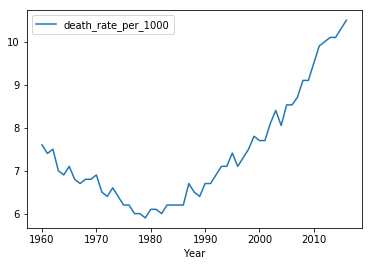

In [12]:
world_death_rates = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_death_rates.csv")
world_death_rates

japan_death_rate = world_death_rates[world_death_rates['Country Name'] == 'Japan']

japan_death_rate = japan_death_rate.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_death_rate['Year'] = japan_death_rate.index
japan_death_rate.columns = ['death_rate_per_1000', 'Year']

japan_death_rate.index = [i for i in range(0,len(japan_death_rate.index))]
japan_death_rate
japan_death_rate['Year'] = pd.to_numeric(japan_death_rate['Year'], errors='coerce')
japan_death_rate['death_rate_per_1000'] = pd.to_numeric(japan_death_rate['death_rate_per_1000'], errors='coerce')
japan_death_rate.plot.line(x='Year', y='death_rate_per_1000')

### Retrieve and Clean Life Expectancy at Birth Data

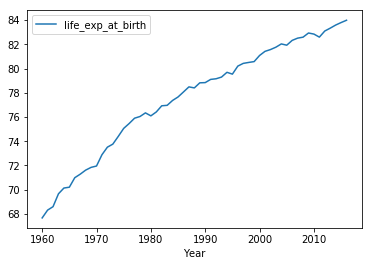

In [13]:
world_life_exp = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_life_expectancy.csv")
world_life_exp

japan_life_exp = world_life_exp[world_life_exp['Country Name'] == 'Japan']

japan_life_exp = japan_life_exp.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_life_exp['Year'] = japan_life_exp.index
japan_life_exp.columns = ['life_exp_at_birth', 'Year']

japan_life_exp.index = [i for i in range(0,len(japan_life_exp.index))]

japan_life_exp['Year'] = pd.to_numeric(japan_life_exp['Year'], errors='coerce')
japan_life_exp['life_exp_at_birth'] = pd.to_numeric(japan_life_exp['life_exp_at_birth'], errors='coerce')
japan_life_exp.plot.line(x='Year', y='life_exp_at_birth')

### Retrieve and Clean Workforce Age Dependancy Data


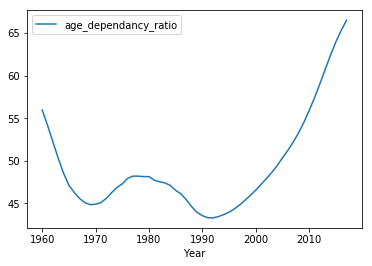

In [14]:
r3 = requests.get("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_age_dependancy_ratio.csv")
raw_world_age_dep = BeautifulSoup(r3.text)

raw_world_age_dep = raw_world_age_dep.getText().split("\n")[4:]

cols = None

japan_age_dep = []

for obs in raw_world_age_dep:
  if cols is not None:
    japan_age_dep.append(obs.replace("\"", '').split(",")[:-1])
  else:
    cols = obs.replace("\"", '').split(",")

df = pd.DataFrame(data=japan_age_dep, columns = cols)
japan_age_dep = df[df['Country Name'] == 'Japan']
japan_age_dep = japan_age_dep.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code' ]).T

japan_age_dep['Year'] = japan_age_dep.index
japan_age_dep.columns = ['age_dependancy_ratio', 'Year']
japan_age_dep.index = [i for i in range(0,len(japan_age_dep.index))]

japan_age_dep['Year'] = pd.to_numeric(japan_age_dep['Year'], errors='coerce')
japan_age_dep['age_dependancy_ratio'] = pd.to_numeric(japan_age_dep['age_dependancy_ratio'], errors='coerce')
japan_age_dep.plot.line(x='Year', y='age_dependancy_ratio')

### Merge All Japanese Feature Sets

In [15]:
from functools import reduce
japan_feature_sets = [total_pop, japan_life_exp, japan_age_dep, japan_death_rate, japan_fert_rate, japan_urban_pop]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Year'), japan_feature_sets)
df_final

,Year,population,pop_delta,pop_delta_delta,pd_decrease,life_exp_at_birth,age_dependancy_ratio,death_rate_per_1000,births_per_woman_japan,births_per_woman_world,urban_population_count
0,1960,90095237,3787852.0,-1792606.0,0.321229,67.666098,55.969005,7.600000,2.001,4.984026,58526962.0
1,1965,94410484,4315247.0,527395.0,-0.139233,70.201951,47.129502,7.100000,2.139,5.049588,67107937.0
2,1970,99279008,4868524.0,553277.0,-0.128214,71.950244,44.904240,6.900000,2.135,4.770691,75000056.0
3,1975,106016074,6737066.0,1868542.0,-0.383801,75.057317,47.292202,6.200000,1.909,4.155118,84756490.0
4,1980,110838758,4822684.0,-1914382.0,0.284157,76.091707,48.144384,6.100000,1.750,3.722379,88958689.0
5,1985,114593751,3754993.0,-1067691.0,0.221389,77.650488,46.528320,6.200000,1.760,3.542499,92632808.0
6,1990,116920564,2326813.0,-1428180.0,0.380342,78.836829,43.561396,6.700000,1.540,3.258953,95542280.0
7,1995,118701910,1781346.0,-545467.0,0.234427,79.536341,43.974416,7.410000,1.422,2.856235,97862490.0
8,2000,119882543,1180633.0,-600713.0,0.337224,81.076098,46.558394,7.700000,1.359,2.667891,99760751.0
9,2005,120513290,630747.0,-549886.0,0.465755,81.925122,50.335955,8.530754,1.260,2.570386,109856670.0


population growth -> https://data.worldbank.org/indicator/SP.URB.GROW?locations=JP

https://data.worldbank.org/indicator/SP.POP.DPND?locations=JP

https://data.worldbank.org/indicator/SP.DYN.LE00.IN?locations=JP


In [16]:
df_final['urban_ratio'] = df_final['urban_population_count'] / df_final['population']
df_final

,Year,population,pop_delta,pop_delta_delta,pd_decrease,life_exp_at_birth,age_dependancy_ratio,death_rate_per_1000,births_per_woman_japan,births_per_woman_world,urban_population_count,urban_ratio
0,1960,90095237,3787852.0,-1792606.0,0.321229,67.666098,55.969005,7.600000,2.001,4.984026,58526962.0,0.649612
1,1965,94410484,4315247.0,527395.0,-0.139233,70.201951,47.129502,7.100000,2.139,5.049588,67107937.0,0.710810
2,1970,99279008,4868524.0,553277.0,-0.128214,71.950244,44.904240,6.900000,2.135,4.770691,75000056.0,0.755447
3,1975,106016074,6737066.0,1868542.0,-0.383801,75.057317,47.292202,6.200000,1.909,4.155118,84756490.0,0.799468
4,1980,110838758,4822684.0,-1914382.0,0.284157,76.091707,48.144384,6.100000,1.750,3.722379,88958689.0,0.802596
5,1985,114593751,3754993.0,-1067691.0,0.221389,77.650488,46.528320,6.200000,1.760,3.542499,92632808.0,0.808358
6,1990,116920564,2326813.0,-1428180.0,0.380342,78.836829,43.561396,6.700000,1.540,3.258953,95542280.0,0.817155
7,1995,118701910,1781346.0,-545467.0,0.234427,79.536341,43.974416,7.410000,1.422,2.856235,97862490.0,0.824439
8,2000,119882543,1180633.0,-600713.0,0.337224,81.076098,46.558394,7.700000,1.359,2.667891,99760751.0,0.832154
9,2005,120513290,630747.0,-549886.0,0.465755,81.925122,50.335955,8.530754,1.260,2.570386,109856670.0,0.911573


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
#DROP unneeded columns
#total_pop.drop(total_pop.index[:2], inplace=True)
df_final = df_final.drop(columns = ['births_per_woman_world'])
reg = LinearRegression()
# trains the x's without population to predict population
labels = df_final['population']
train1 = df_final.drop(['population'],axis=1)

x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.10,random_state =2)
#do the regression
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.30150409508554887

Next we run our data through multiple regression and score it to see how accurately it can depict this relationship. We split the data into training(x) and results(y). We then split these two dataframes 90:10 training and scoring, respectively. After we reach our score, we wonder if a different method might yield an even higher score. This score is not good, so we're definitely give the other one a go!

In [20]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
#same thing but using gradient boosting
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

0.94721420306014303

This is where we learned about Gradient Descent Boosting. To our understanding, gradient boosting works using improvement on three factors. These factors being optimizing a loss function, using decision trees as greedy weak learner, and an additive model that utilizes these weak learners in an attempt to minimize the loss. This score is much better than our multiple regression so we'll opt to use this as a better representation of the relationships between our variables.

#### Enter the Hinoe Uma(Fire Horse)

Japanese society is extremely homogenous with 99.5% of the population in Japan being ethnically Japanese. As such, this ethnic homogeneity lends itself to widespread beliefs about topics such as work culture, but also in this case superstition. Hinoe Uma, or Fire Horse, is the 43rd combination of the sexagenary cycle. It is believed that children born this year have bad personalities and so many people will actively avoid giving birth during this year. As such, birthrates for this year fall dramatically every time it comes around. This is due to the average childbearing couple in Japan having only one child, and as such want to avoid all risks.



 The reason that Hinoe Uma is important, is that the Japanese population and workforce is already shrinking at an incredible rate.Hinoe Uma comes in 60 year cycles. The last time it occurred in 1966, causing a roughly 25.9% decline in birthrates for that year. In the year after, it recovered, but the Japanese birthrate was incredibly high at this time due to still being in the process of industrialization. 2026 is the next time Hinoe Uma will occur, without a doubt causing another sharp decline in birthrates. However, this time Japanese birthrates are already at a historical low with no sign of changing in sight. A dramatic decrease in birthrates during the midst of a decline means that Japan misses out on a crucial amount of new children that will likely not be recovered due to the decline that's projected to continue year after year. Hinoe Uma also contribute to a permanent decrease in birthrates for the years after, although causes a high spike the year or two after due to compensation. This is seen as the year immediatedely before 1966 had a high amount of growth but after 1970, the population decline fell under 2.00, never to recover in the 48 years since.

It is unlikely that Hinoe Uma singehandedly kicked off population decline for Japan at large. However, with the rapid post-war industrialization and societal shifts regarding the value of material culture, Japan's population was already incredibly vulnerable. A cultural phenoma that caused widespread birthrate decline may have been the spark that lit the fuse on Japan's already shaky views on the importance of childbirth.

It's unreasonable to try to impute the data for 2065, but if for some reasons all factors remain the same and Japanese society still is victim to population decline, Hinoe Uma will return in 2086 to cause more havoc to an already incredibly low population growth.

### Conclusion

When we chose this topic, we went into it with a curiousity about this extremely interesting sociological problem. By utilizing the techniques we learned in class, we were able to gain new insight to this problem that many sources online are unaware of. We hypothesized that Japanese population decline was more than just the difference between deathrate and birthrate, and our hunch turned out to be correct. Of course population change is simply that subtraction, but it doesn't speak to any length of the cultural undercurrents causing this change. Our project aimed to identify these factors and display their effect on a society.

As we continued with the project, our goals became more and more lofty. We created a regression model and refined our predictions by opting for a more accurate gradient descent boosting algorithm. This allowed us to predict population changes with features that we had identified as having a linear relationship with population decline. 

As we pored over the data we had found, we found strange anomalies, most notably in 1966. We had found the cultural phenomena known natively as Hinoe Uma. This phenomena caused dramatic decline in the year it was present, but had it been in any other society, its effects would hardly be notiacble. However, this was Japan and its effects are much more impactful.

Now, we know that Japanese population decline is more than just those two features. It depends on urban population, age of workforce, and female literacy and achievement, as well as many more features that we weren't able to cover. This all underscored by what is to come in 2026, which will cause Japan to lose millions more of its population in the years following.